# Understanding the data

Let's start by understanding our objective and the data we have selected for this task.

In essence, a machine learning model functions similarly to a mathematical funcion that takes specific inputs and produces predictions. Instead of coding complex rules manually, we train the model using numerous examples, allowing it to learn the patterns. During training, we provide it with correct answers, or labels, ƒor each input, which are crucial for its learning process. Each training instance comprises a pair consisting of inputs and their corresponding labels.

For this project, we aim to develop a straightforward model for land cover classification, using the [Dynamic World](https://dynamicworld.app/) dataset. The DwLCDB is a collection of land cover maps that represent the Earth's surface at a 30m resolution. Each pixel in the map is assigned a specific land cover class, such as forest, water, or urban area. The dataset contains several features, such as the spectral bands of the pixels, the land cover class, and the quality of the classification. Land cover data is vital across various fields, including climate research, energy, water, management, agriculture, conservation, and more. The framework we develop for this model can be adapted for many other similar tasks.

# Earth Engine Basics

[Google Earth Engine](https://earthengine.google.com/) is a cloud-based platform that allows users to access a vast amount of geospatial data and perform complex analyses. It provides a wide range of datasets, including satellite imagery, climate data, and land cover maps. Earth Engine also offers a JavaScript API that enables users to interact with the platform and perform various geospatial tasks. It amalgamates petabytes of geospatial data and offers a suite of functions for its processing and analysis. We'll be utilizing the Earth Engine Python client library for our tasks, although you can explore different methods of interfacing with Earth Engine by checking the [API Reference](https://developers.google.com/earth-engine/apidocs) page.

Here are some fundamental concepts in Earth Engine:

- Band: A band is essentially a matrix, containing pixel values. Each pixel within a band holds a single numeric value, which can be in various forms such as bytes, integers, or floats.
- [Image](https://developers.google.com/earth-engine/guides/image_overview): Images in Earth Engine consist of one or more bands, each identified by a unique name.
- [ImageCollection](https://developers.google.com/earth-engine/guides/ic_creating): This refers to a set of images, functioning similarly to a list, containing zero or more images.
- [Geometry](https://developers.google.com/earth-engine/guides/geometries): This typically refers to geospatial data points, which can be a single point coordinate, a polygon, or a multi-polygon.
- [Feature](https://developers.google.com/earth-engine/guides/features): A feature in Earth Engine includes a Geometry paired with a value.
- [FeatureCollection](https://developers.google.com/earth-engine/guides/feature_collections): Similar to ImageCollection, this is a compilation of zero or more features, comparable to a list of features.
- [Scale](https://developers.google.com/earth-engine/guides/scale): This term describes the pixel resolution of an image, which is measured in meters.

In [14]:
from datetime import datetime, timedelta
import folium
import ee

import io

from google.api_core import exceptions, retry
import google.auth
import numpy as np
from numpy.lib.recfunctions import structured_to_unstructured
import requests
import geemap

# Google Cloud Resources

Make sure you have followed these steps to configure your Google Cloud project:

Enable the APIs: [Earth Engine](https://console.cloud.google.com/flows/enableapi?apiid=earthengine.googleapis.com)

Register your [Compute Engine default service account](https://signup.earthengine.google.com/#!/service_accounts) on Earth Engine.


Once you have everything ready, you can go ahead and fill in your Google Cloud resources in the following code cell. Make sure you run it!

In [15]:
PROJECT = "bigdata-ahhcash"

In [16]:
# Use cli to authenticate
# !earthengine authenticate

# Or use the following code to authenticate
def initialize_ee():
  ee.Authenticate()
  ee.Initialize(project=PROJECT, opt_url="https://earthengine-highvolume.googleapis.com")

initialize_ee()

In [17]:
WORLD_POLYGONS = [
    # Americas
    [(-33.0, -7.0), (-55.0, 53.0), (-166.0, 65.0), (-68.0, -56.0)],
    # Africa, Asia, Europe
    [
        (74.0, 71.0),
        (166.0, 55.0),
        (115.0, -11.0),
        (74.0, -4.0),
        (20.0, -38.0),
        (-29.0, 25.0),
    ],
    # Australia
    [(170.0, -47.0), (179.0, -37.0), (167.0, -12.0), (128.0, 17.0), (106.0, -29.0)],
]
POLYGON = [(-140.0, 60.0), (-140.0, -60.0), (-10.0, -60.0), (-10.0, 60.0)]

LANDSAT_DATASET = "LANDSAT/LC08/C02/T1_L2"
LANDSAT_BANDS = ["SR_B4", "SR_B3", "SR_B2"]
LANDSAT_VIS_PARAMS = {"bands": LANDSAT_BANDS, "min": 0, "max": 0.3}

SENTINEL_DATASET = "COPERNICUS/S2_HARMONIZED"
SENTINEL_BANDS = ["B4", "B3", "B2"]
SENTINEL_VIS_PARAMS = {"bands": SENTINEL_BANDS, "min": 0, "max": 3000}

DYNAMIC_WORLD_DATASET = "GOOGLE/DYNAMICWORLD/V1"

# Helper Functions

In [36]:
def mask_sentinel2_clouds(image: ee.Image) -> ee.Image:
    """Mask clouds in Sentinel-2 images."""
    CLOUD_BIT = 10
    CIRRUS_CLOUD_BIT = 11
    bit_mask = (1 << CLOUD_BIT) | (1 << CIRRUS_CLOUD_BIT)
    mask = image.select("QA60").bitwiseAnd(bit_mask).eq(0)
    return image.updateMask(mask)

def mask_landsat8_clouds(image: ee.Image) -> ee.Image:
    """Mask clouds in Landsat 8 images."""
    CLOUD_SHADOW_BIT = 3
    CLOUD_BIT = 5
    qa = image.select('QA_PIXEL')
    cloud_mask = qa.bitwiseAnd(1 << CLOUD_SHADOW_BIT).eq(0) \
                   .And(qa.bitwiseAnd(1 << CLOUD_BIT).eq(0))
    return image.updateMask(cloud_mask)

def get_landsat_image(year: int, default_value: float = 0.0) -> ee.Image:
    """Get a Landsat image for the given year."""
    return (
        ee.ImageCollection(LANDSAT_DATASET)
        .filterDate(f"{year}-1-1", f"{year}-12-31")
        .map(mask_landsat8_clouds)
        .map(apply_scale_factors)
        .median()
        .unmask(default_value)
        .float()
    )

def apply_scale_factors(image):
    """Apply scale factors to Landsat 8 bands."""
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, None, True).addBands(
        thermal_bands, None, True
    )

def get_sentinel_image(year: int, default_value: float = 1000.0) -> ee.Image:
    """Get an input image for the given year."""
    return (
        ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
        .filterDate(f"{year}-1-1", f"{year}-12-31")
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 20))
        .map(mask_sentinel2_clouds)
        .select("B.*")
        .median()
        .unmask(default_value)
        .float()
    )

# Satellite Imagery Dataset Comparison

The Dynamic World Land Cover Database (DwLCDB) is a collection of land cover maps that represent the Earth's surface at a 30m resolution. The dataset contains land cover classes such as forest, water, urban area, and cropland. The DwLCDB is derived from satellite imagery, such as Sentinel-2 and Landsat 8, and is available through the Google Earth Engine platform. The dataset is useful for various remote sensing applications, including land cover classification, vegetation monitoring, and change detection.

### Here's a comparison of the Sentinel-2 and Landsat 8 datasets:

### <u>Sentinel-2</u>

The Sentinel-2 is a part of the European Space Agency's Copernicus program. It comprises two satellites, Sentinel-2A and Sentinel-2B, which capture high-resolution multispectral imagery of the Earth's surface. The Sentinel-2 satellites have 13 spectral bands, ranging from visible to shortwave infrared. These bands are crucial for various remote sensing applications, including land cover classification, vegetation monitoring, and change detection. The Sentinel-2 data is freely available through the Copernicus Open Access Hub and the Google Earth Engine platform. 

Here's a satellite image overlooking New York City, captured by the Sentinel-2 satellites. For visualization, bands (B4, B3, B2) correspond to (Red, Green, Blue) respectively.

In [19]:
import folium

image = get_sentinel_image(2021)
folium.Map(
    location=(40.785091, -73.968285),
    zoom_start=9,
    tiles=image.getMapId(SENTINEL_VIS_PARAMS)["tile_fetcher"].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    scrollWheelZoom=False,
    dragging=False
)

In [20]:
image = get_sentinel_image(2021)
folium.Map(
    location=(40.785091, -73.968285),
    zoom_start=12,
    tiles=image.getMapId(SENTINEL_VIS_PARAMS)["tile_fetcher"].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    scrollWheelZoom=False,
    dragging=False
)

### <u>Landsat 8</u>

The Landsat 8 satellite is part of the Landsat program, a joint initiative between NASA and the US Geological Survey (USGS). Landsat 8 captures multispectral imagery of the Earth's surface, with a focus on monitoring land cover, vegetation, and environmental changes. The satellite has 11 spectral bands, ranging from visible to thermal infrared. These bands are essential for various remote sensing applications, including land cover classification, crop monitoring, and forest mapping. The Landsat 8 data is freely available through the USGS Earth Explorer platform and the Google Earth Engine platform.

Here's a satellite image captured by the Landsat 8 satellite, overlooking New York City. The Landsat 8 satellite also captures other bands, such as the near-infrared and shortwave infrared, which are useful for extracting additional information about the land cover and vegetation.

In [37]:
dataset = get_landsat_image(2021)
m = geemap.Map()
m.set_center(-73.968285, 40.785091, 9)
m.scroll_wheel_zoom = False
m.dragging = False
m.add_layer(dataset, LANDSAT_VIS_PARAMS, 'Landsat 8 Satellite Image')
m

Map(center=[40.785091, -73.968285], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sea…

In [28]:
m = geemap.Map()
m.set_center(-73.968285, 40.785091, 12)
m.scroll_wheel_zoom = False
m.dragging = False
m.add_layer(dataset, LANDSAT_VIS_PARAMS, 'Landsat 8 Satellite Image')
m

Map(center=[40.785091, -73.968285], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Sea…

# Choosing the Dataset

We have decided to use the Landsat 8 dataset for our land cover classification task. Landsat 8 is a multispectral satellite that captures high-resolution imagery of the Earth's surface. The satellite has 11 spectral bands, ranging from visible to thermal infrared, which are essential for various remote sensing applications. The Landsat 8 data is freely available through the US Geological Survey (USGS) Earth Explorer platform and the Google Earth Engine platform.

Here are some reasons why we chose the Landsat 8 dataset:

1. **Spectral Bands**: Landsat 8 has 11 spectral bands, which provide a wide range of information about the Earth's surface. These bands are crucial for land cover classification, vegetation monitoring, and change detection.

2. **Resolution**: Landsat 8 captures imagery at a 30m resolution, which is suitable for various remote sensing applications. The high resolution allows us to distinguish different land cover classes and features on the Earth's surface.

3. **Availability**: Landsat 8 data is freely available through the USGS Earth Explorer platform and the Google Earth Engine platform. This accessibility makes it easier for researchers and scientists to access and use the data for their projects.

4. **Historical Data**: Landsat 8 has been capturing imagery since 2013, providing a historical record of the Earth's surface. This historical data is valuable for monitoring changes in land cover, vegetation, and environmental conditions over time.

5. **Validation**: Landsat 8 data has been extensively validated and used in various remote sensing applications. The accuracy and reliability of the data make it a suitable choice for land cover classification tasks.



# Dynamic World Land Cover Database (DwLCDB)

Based on the previous description of the Dynamic World dataset, we can infer that it is a valuable resource for land cover classification tasks. Given below is the land cover legend for the DwLCDB dataset:

1. Water
2. Urban area
3. Cropland
4. Grassland
5. Shrubland
6. Forest
7. Bare ground
8. Snow and ice

We will display another image from the DwLCDB dataset to provide a visual representation of the land cover classes. This image will help us understand the different land cover types and their distribution across the Earth's surface. The image overlooks New York City and shows the land cover classes present in the area. The land cover legend will be displayed alongside the image to help us identify the different classes.

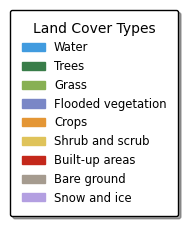

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# Define your classes and their corresponding colors
CLASS_NAMES = [
    'Water', 'Trees', 'Grass', 'Flooded vegetation',
    'Crops', 'Shrub and scrub', 'Built-up areas', 'Bare ground', 'Snow and ice'
]
COLORS = [
    '#419bdf', '#397d49', '#88b053', '#7a87c6',
    '#e49635', '#dfc35a', '#c4281b', '#a59b8f', '#b39fe1'
]

# Create a list of patches for the legend
patches = [mpatches.Patch(color=COLORS[i], label=CLASS_NAMES[i]) for i in range(len(CLASS_NAMES))]

# Create the legend
plt.figure(figsize=(0, 0))
plt.legend(handles=patches, loc='center', title='Land Cover Types', fontsize='small', shadow=True, fancybox=True, facecolor='white', edgecolor='black', borderpad=1)
plt.axis('off')  # Turn off the axis
plt.show()


# Helper function to display image

In [24]:
import ee
import folium

def get_dynamic_world_image(year: int) -> ee.Image:
    """Get the Dynamic World image for 2021."""
    image = ee.ImageCollection(DYNAMIC_WORLD_DATASET)\
                .filter(ee.Filter.date(f"{year}-1-1", f"{year}-12-31"))\
                .select('label')\
                .mode()\
                .rename('landcover')

    return image.byte()

# Generate a folium map
def generate_dw_map(year: int, location, zoom_start=9, width="100%", height="100%") -> folium.Map:
    """Generate a Dynamic World map for the given year."""
    DYNAMIC_WORLD_VIS_PARAMS = {
        'bands': ['landcover'],
        'min': 0,
        'max': 8,
        'palette': [
            '419BDF',    # Water
            '397D49',    # Trees
            '88B053',    # Grass
            'E1C340',    # Flooded Vegetation
            'DC9A26',    # Crops
            'C44A22',    # Scrub/Shrub
            'A16943',    # Built Area
            'B39FE1',    # Bare Ground
            '6F6F6F'     # Snow/Ice
        ]
    }
    my_map = folium.Map(
        location=location, 
        zoom_start=zoom_start, 
        width=width, 
        height=height, 
        scrollWheelZoom=False,
        dragging=False
    )

    image = get_dynamic_world_image(year)

    my_map.add_ee_layer(image, DYNAMIC_WORLD_VIS_PARAMS, 'Dynamic World')

    return my_map

def add_ee_layer(self, ee_image_object, vis_params, name):
    """Add a method for displaying Earth Engine image tiles on folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

# Dynamic World Land Cover Image

The image below displays the land cover classes present in New York City, as captured by the Dynamic World Land Cover Database (DwLCDB). The image provides a visual representation of the different land cover types, such as water, urban area, cropland, grassland, shrubland, forest, bare ground, and snow and ice. The land cover legend is displayed alongside the image to help identify the different classes. The image highlights the diversity of land cover types in urban areas and the surrounding regions. 

Our model will be trained on similar images to classify the land cover classes accurately. The model will learn the patterns and features associated with each class, enabling it to make predictions on new images. The DwLCDB dataset is a valuable resource for land cover classification tasks, providing high-resolution land cover maps that cover the Earth's surface. The dataset is useful for various remote sensing applications, including vegetation monitoring, change detection, and environmental analysis.

In [25]:
my_map = generate_dw_map(2016, [40.785091, -73.968285], 12, '100%', '100%')
my_map.add_child(folium.LayerControl())
my_map

In [26]:
my_map = generate_dw_map(2023, [40.785091, -73.968285], 12, '100%', '100%')
my_map.add_child(folium.LayerControl())
my_map